# EXPLORATORY DATA ANALYSIS. 💻🏭📈👨‍💻

## Industrial Plant for Ultra-processed Food Production. ​🥐​🥞​🥜​🥫​🍲​

### Process Descrption:
"The raw data are obtained from an industrial plant for ultra-processed food production. The sampling was carried out every 5 minutes while the total production cycle takes approximately 3 hours, from raw ingredients to final semi- finished products. The extracted data represent approximately 80 days of production. Variables 2 − 14 belonging to 4 specific phases of the process and influence the qualitative variable 17. Variables 15 and 16 are external variables not controlled by the process which affect the final product."

To create an effective process monitoring model, it is essential to thoroughly understand your process data. This practice is known as exploratory data analysis (EDA). In this code, we will explore how to evaluate four key characteristics of a dataset: nonlinearity, non-Gaussianity, dynamics, and multimodality.

In [23]:
# Librerias necesarias.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
import seaborn as sns
import scipy.spatial, scipy.stats
from sklearn.mixture import GaussianMixture
#plt.rcParams.update({'font.size': 20})
plt.rcParams['figure.dpi'] = 250 #Esto lo ponemos para mejorar la calidad de las graficas
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [24]:
data = pd.read_csv("DatasetUF.csv")

caract = data.describe()

data_numeric = data.drop(columns=["DateTime"])
name = data_numeric.columns


## Nonlinearity Assessment
When any two variables in a multivariable dataset exhibit a nonlinear relationship, the dataset is said to have nonlinear characteristics.
To evaluate nonlinearity, scatter plots between each pair of variables can be used. However, this method becomes increasingly cumbersome with high-dimensional datasets.

In this part of the code we will calculate the lineal and nonlineal correlation coeffcients. For this, we will use Pearson correlation to measure linearity and mutual information to measure non-linearity.

In [25]:
# Lineal Correlation (Pearson)
# which quantifies the linear dependency between two variables. 
# As is commonly known, 𝜌∈[−1,1] where values of -1 and 1 signify perfect linear correlation.
#rho_xy = data.corr(method="pearson")
rho_xy = np.corrcoef(data_numeric, rowvar= False)


In [26]:
# defiy de function to calculate MI
def pairwise_corr(data):
    l, n = data.shape
    mi_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i == j:
                mi_matrix[i, j] = 1
            else:
                mi_matrix[i, j] = mutual_info_regression(data[:, i].reshape(-1, 1), data[:, j])[0]
    return mi_matrix

In [27]:
# Mutual information (MI) nonlineal correlation
rho_I_xy = pairwise_corr(data_numeric.values) 
np.fill_diagonal(rho_I_xy,1) # fill the diagonal with 1 because is de maxima dependency.


In [28]:
# In this part we combine the matrices (pearson matrix with MI matrix) to obtain a 
# composite measure of the relationship between variables. 

rxy = rho_I_xy * (1 - np.abs(rho_xy)) # This multiplication gives more weight to non-linear relationships when the linear correlation is low and less weight when the linear correlation is high.


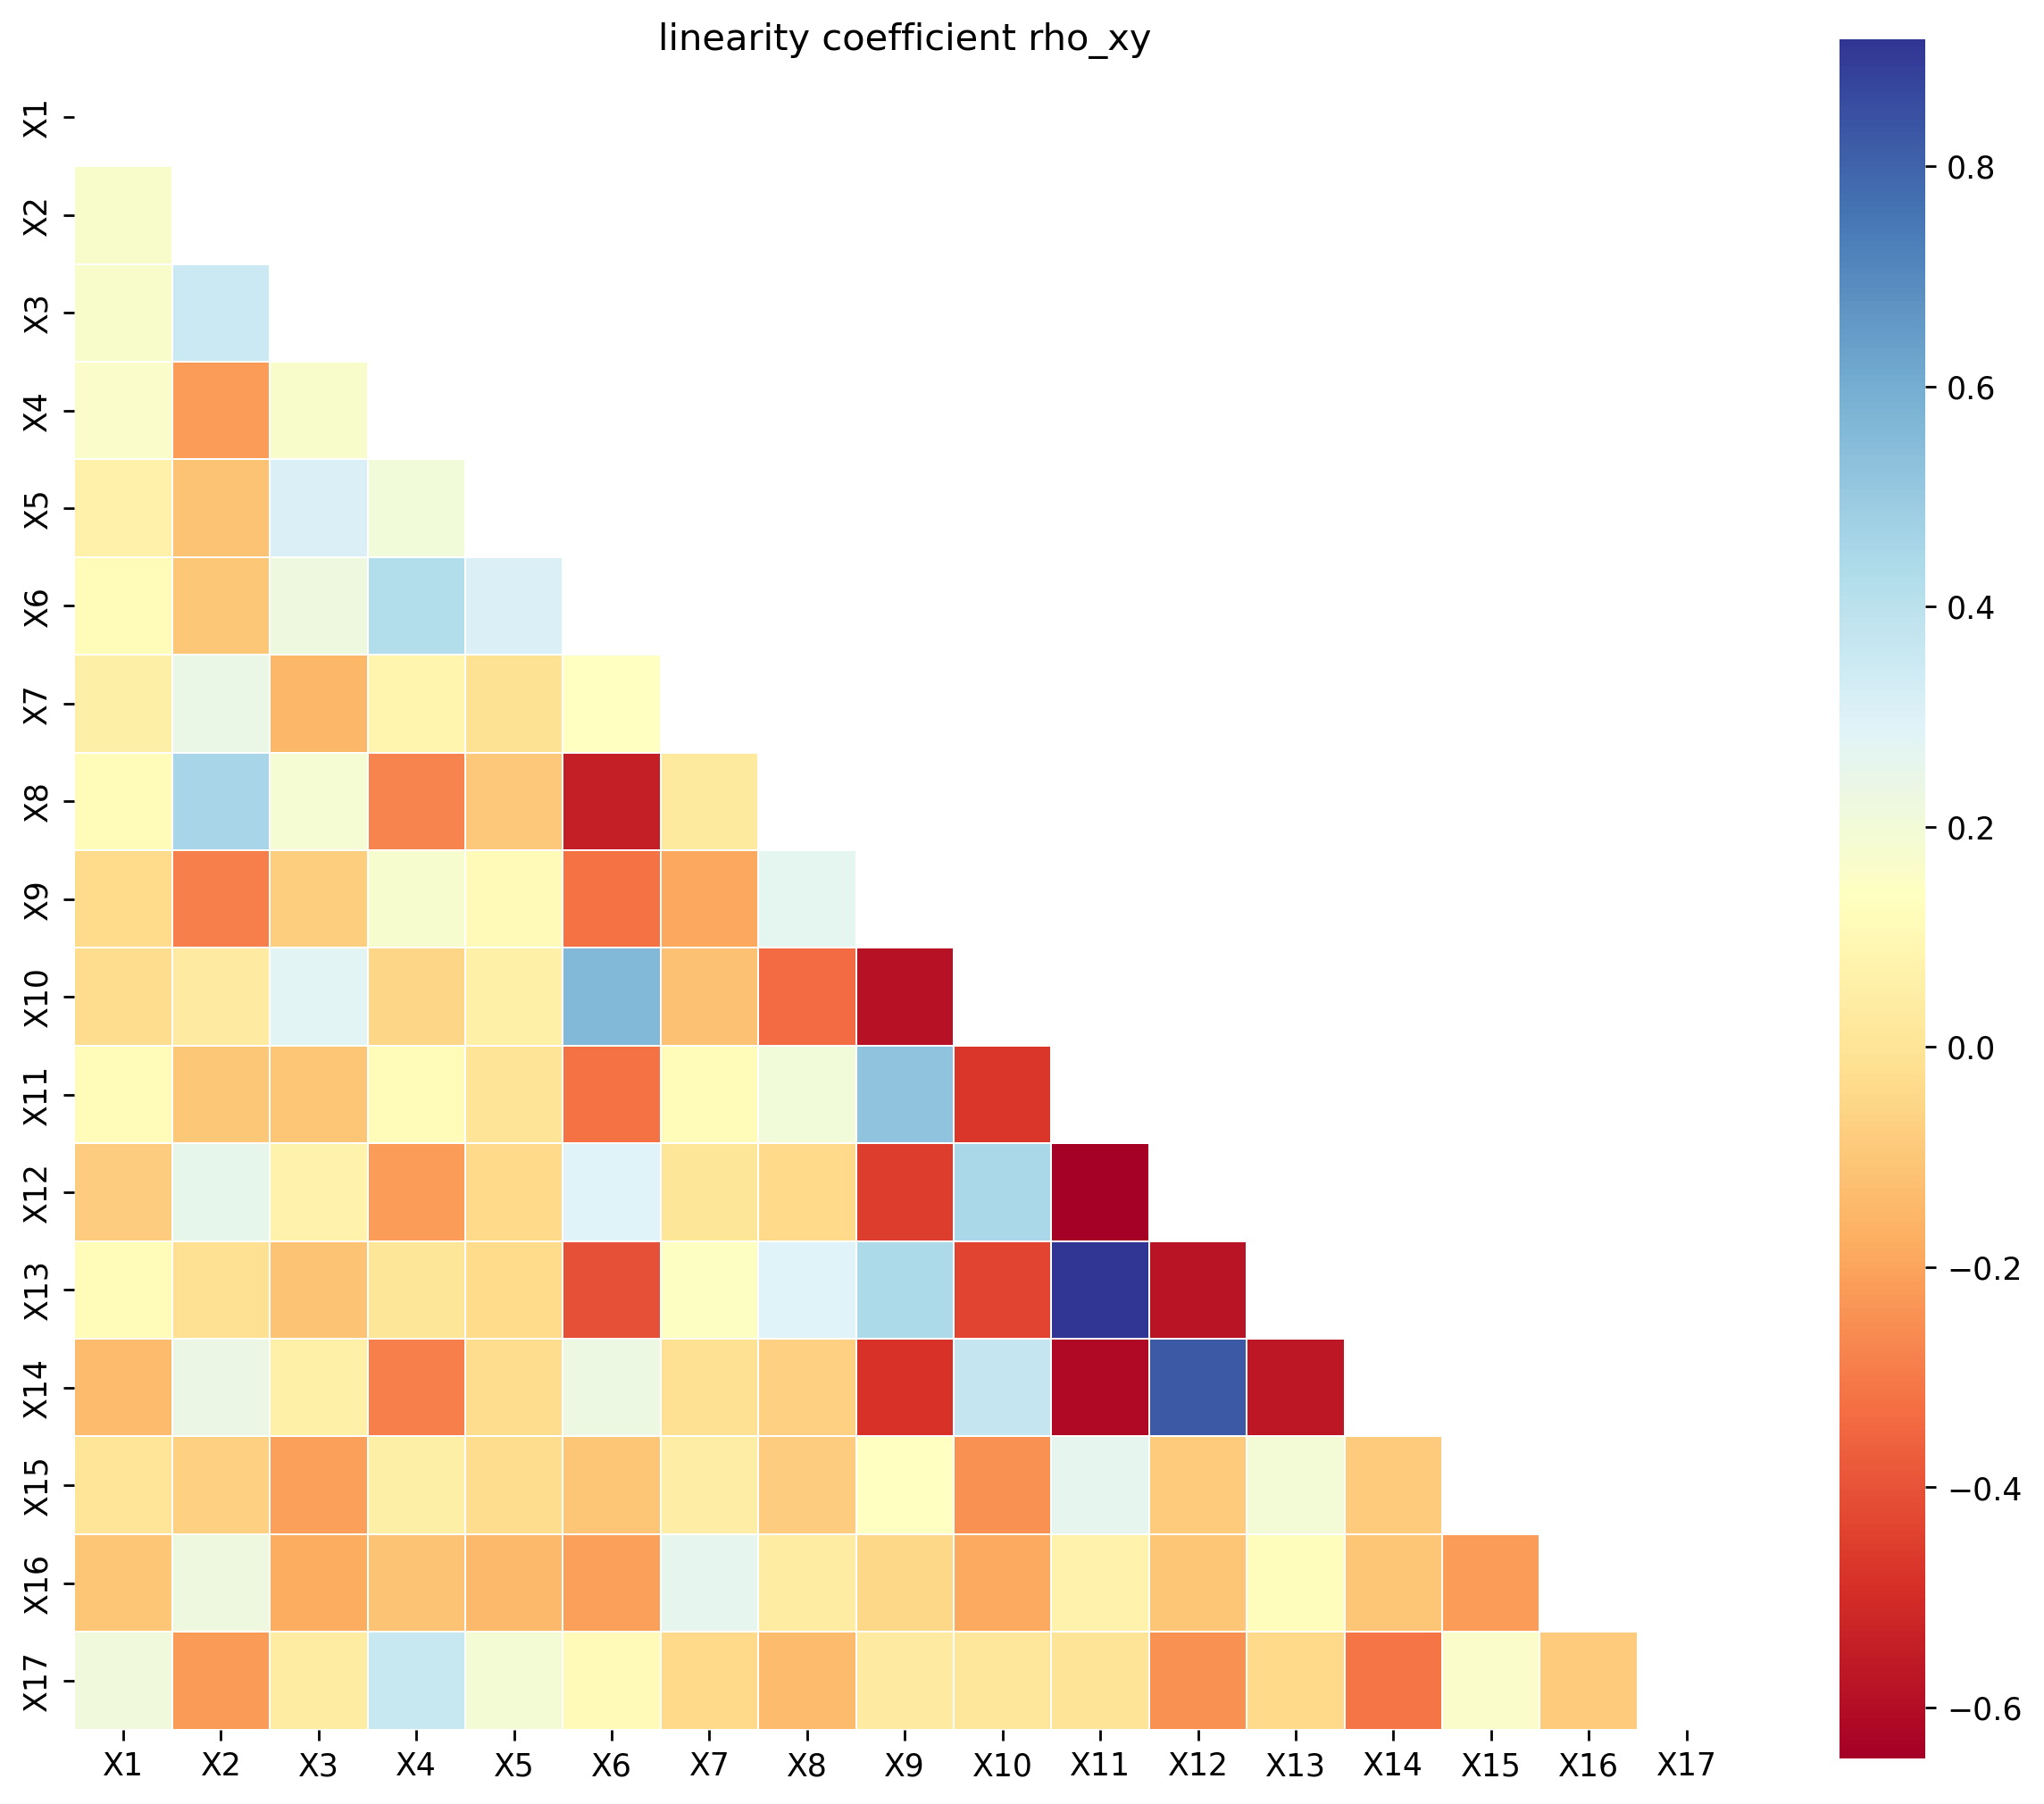

In [29]:
# Heat map of rho_xy
mask = np.triu(np.ones_like(rho_xy, dtype=bool))
plt.figure(figsize=(12,10))
sns.heatmap(rho_xy, linewidth=.5, cbar=True, cmap="RdYlBu", annot=True, fmt=".3f",
             annot_kws={"size": 12}, square=True, mask = mask, yticklabels=name, xticklabels=name )
plt.title("linearity coefficient rho_xy")
plt.tick_params(axis="both", labelsize=10)
plt.show()

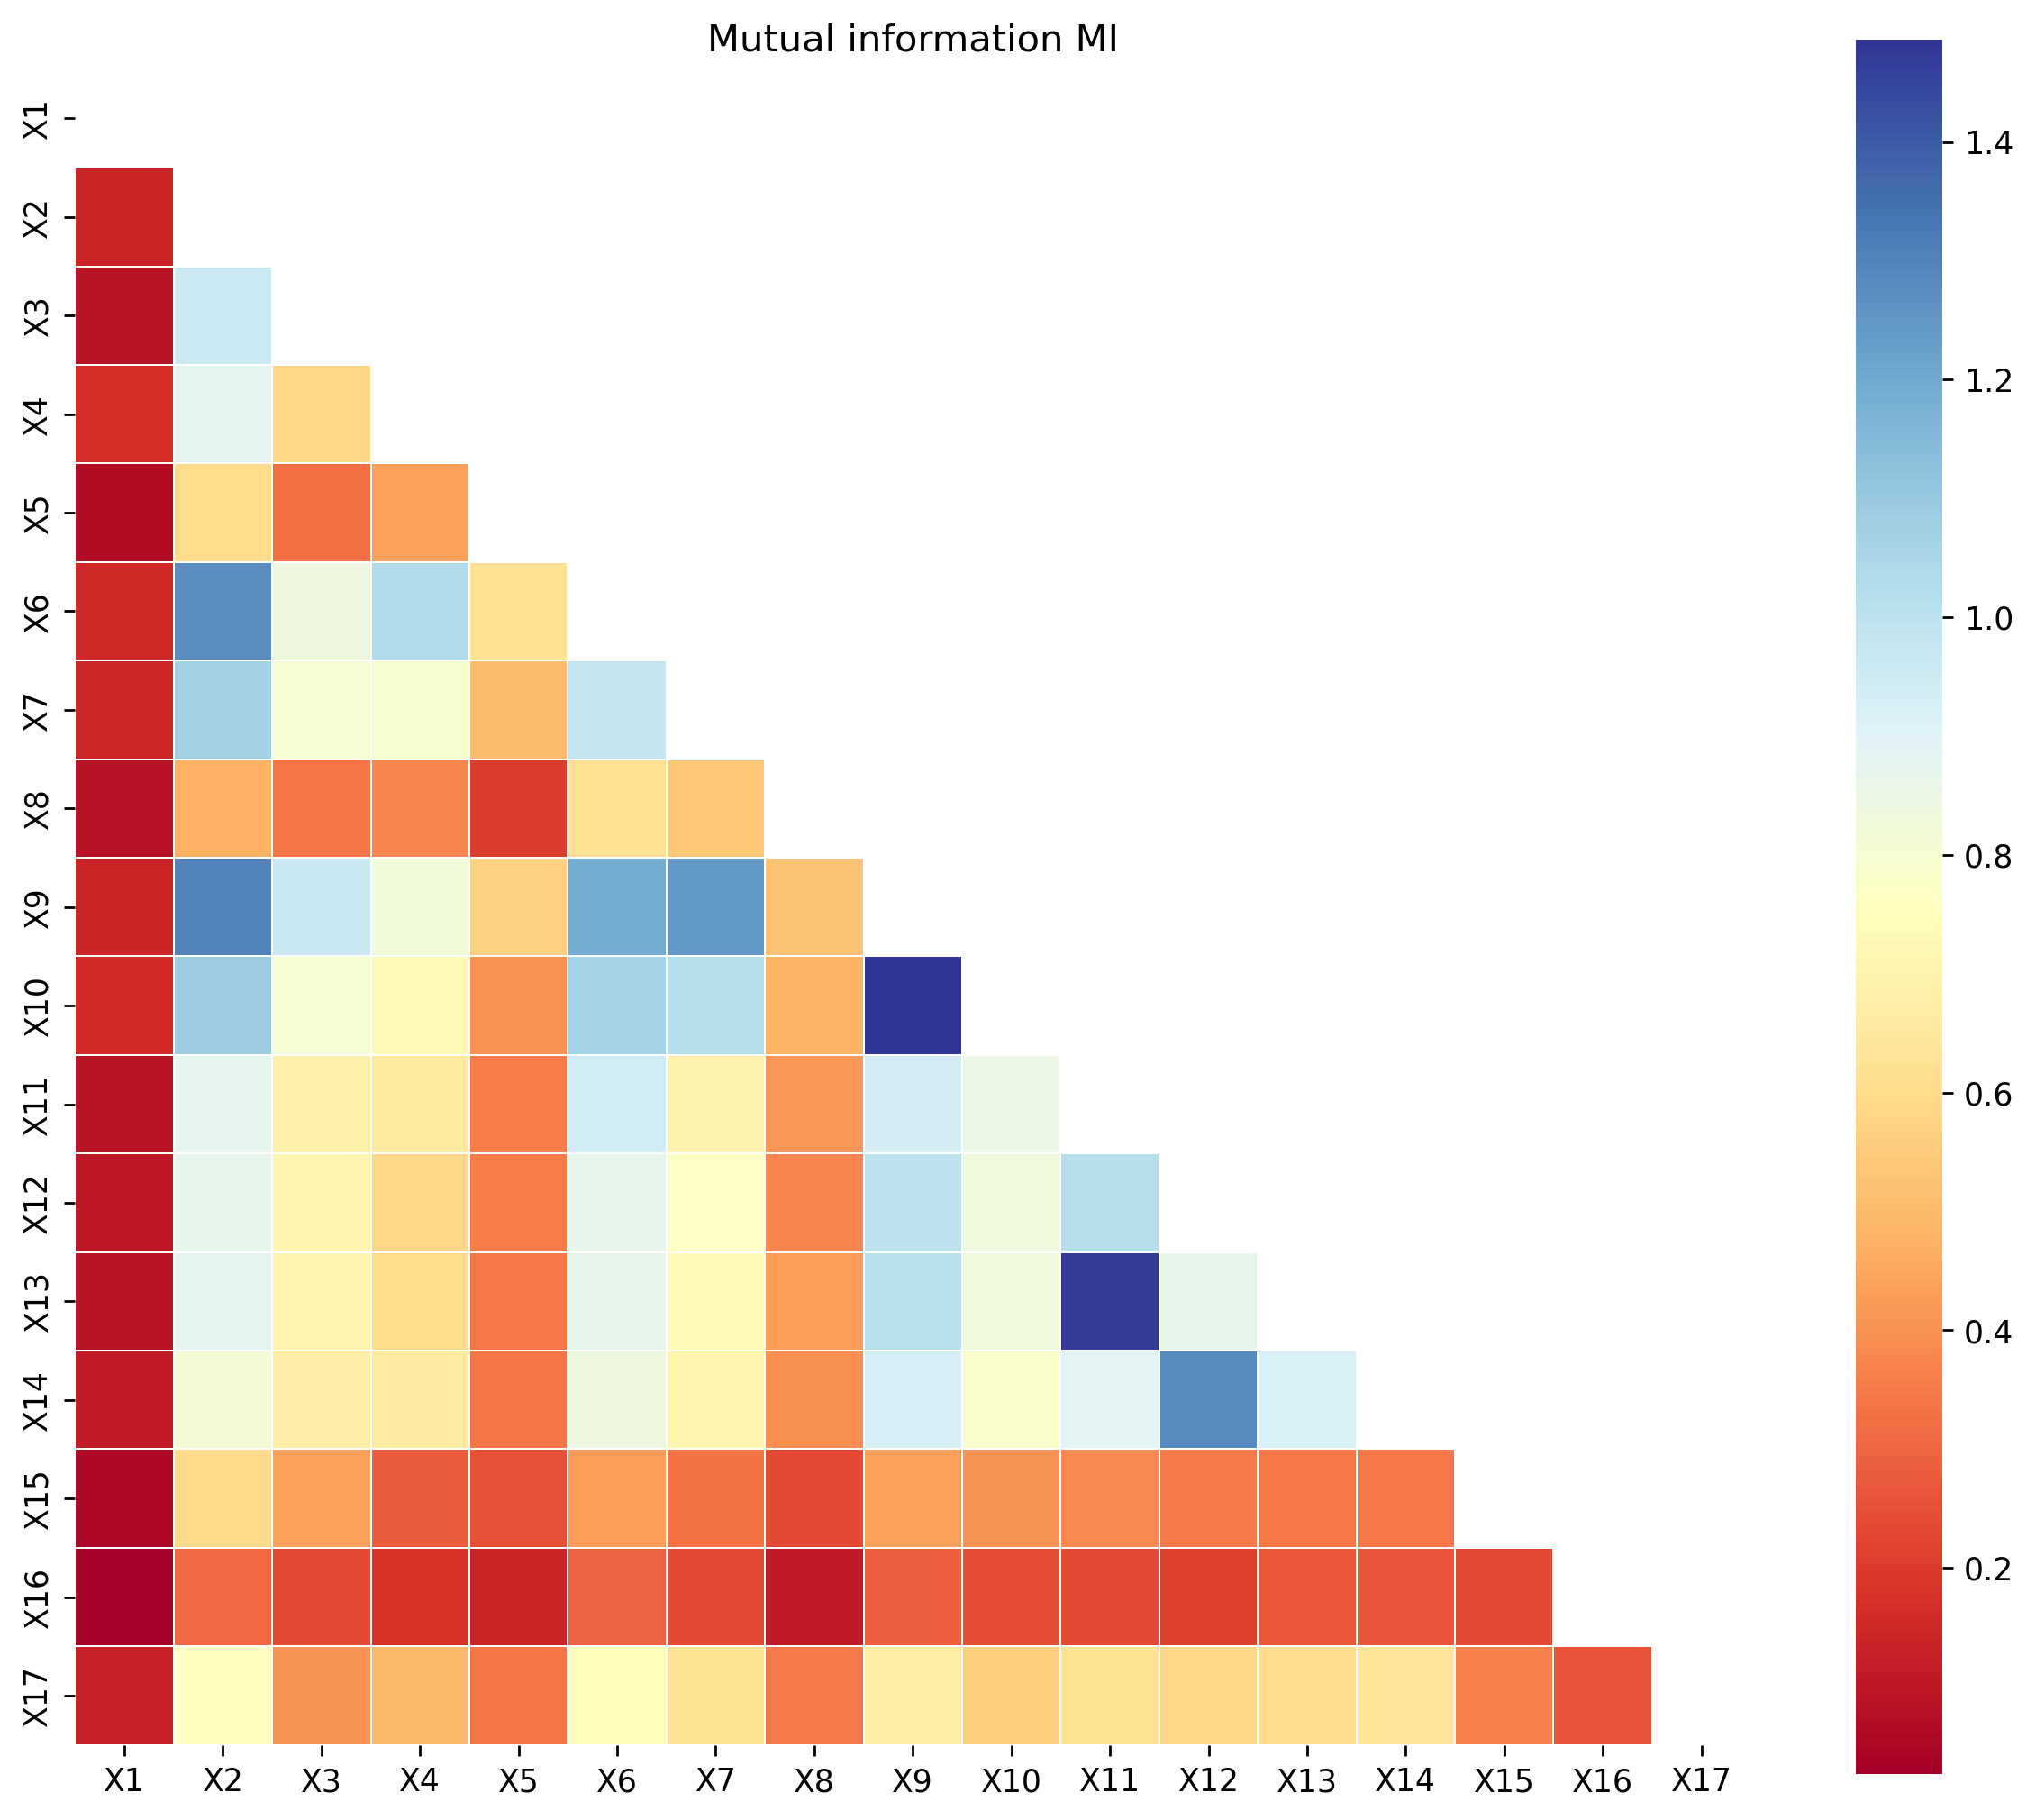

In [30]:
# Heat map of rho_I_xy
mask = np.triu(np.ones_like(rho_I_xy, dtype=bool))
plt.figure(figsize=(12,10))
sns.heatmap(rho_I_xy, linewidth=.5, cbar=True, cmap="RdYlBu", annot=True, fmt=".3f",
             annot_kws={"size": 12},square=True,  yticklabels=name,mask= mask, xticklabels=name) 
plt.title("Mutual information MI")
plt.tick_params(axis="both", labelsize=10)
plt.show()

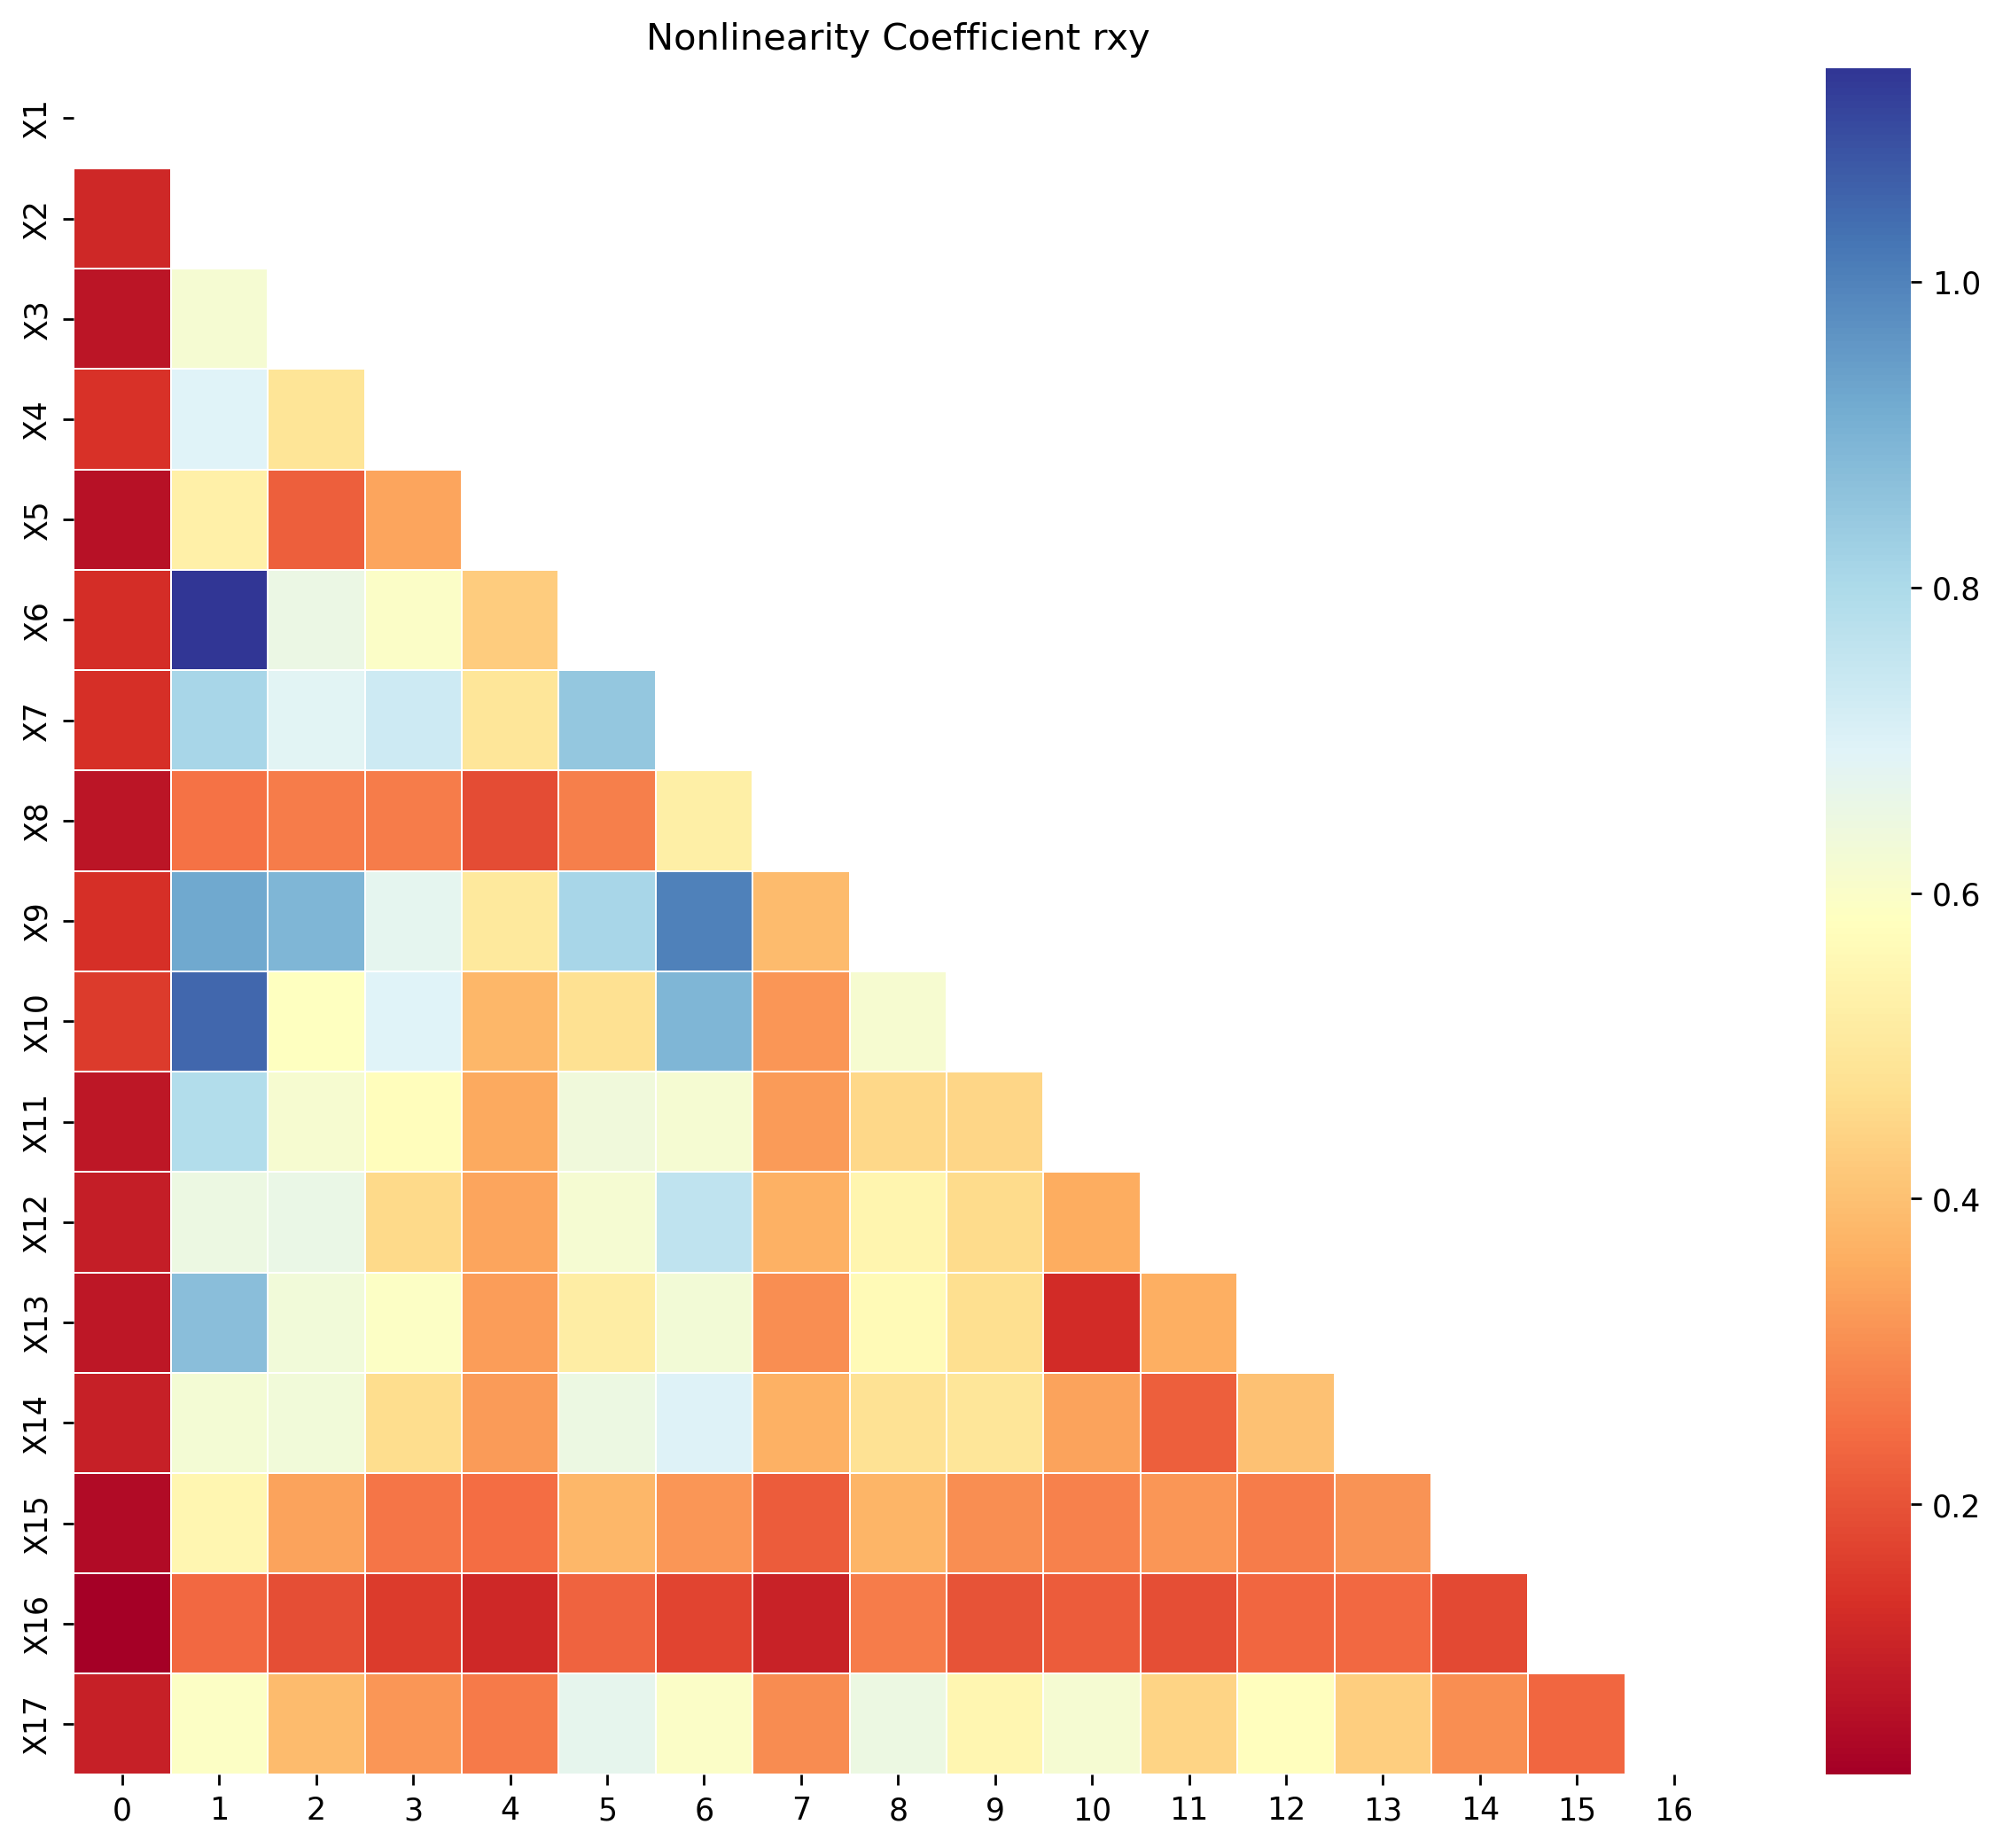

In [31]:
# Heat map of rxy
mask = np.triu(np.ones_like(rxy, dtype=bool))
plt.figure(figsize=(12,10))
sns.heatmap(rxy, linewidth=.5, cbar=True, cmap="RdYlBu", yticklabels=name,mask= mask) 
plt.title("Nonlinearity Coefficient rxy")
plt.tick_params(axis="both", labelsize=10)
plt.show()

### Interpreting the values in the rxy matrix:

The values in rxy indicate the strength of the relationship between the variables, considering both linear and nonlinear relationships. 
* A high value in rxy suggests a strong nonlinear relationship or a moderate relationship that is not purely linear. 
* A low value in rxy suggests a weak relationship or that the relationship is primarily linear and, therefore, does not stand out in this composite measure.

In [32]:
# Global Coefficients of linearity and non-linearity 
m = data_numeric.shape[1]
r = np.sqrt((rxy**2).sum() / (m**2 - m))
rho = np.sqrt(((rho_xy**2).sum() - m) / (m**2 - m))

r, rho

print('Overall nonlinearity coefficient:', r)
print('Overall linearity coefficient:', rho)

Overall nonlinearity coefficient: 0.48647783392588084
Overall linearity coefficient: 0.26362197531634


As observed,  \ r = 0.48 \ , which indicates a nonlinear relationship. This is corroborated by $\rho$ = 0.26 , demonstrating a low Pearson correlation (linear correlation). 

For more information about this nonlinearity coefficient see: Zhang et al., A Novel Strategy of the Data Characteristics Test for Selecting a Process Monitoring Method Automatically. Industrial & Engineering Chemistry Research, 2016 DOI: 10.1021/acs.iecr.5b03525. Pag. 5


## Gaussianity Assessment

Gaussianity assessment is a process that determines whether the data follow a normal distribution, also known as a Gaussian distribution. In simple terms, it involves checking if the data form a bell-shaped curve when plotted graphically.
Incorrect assumptions about the Gaussianity of process data can result in an inaccurate determination of the NOC (Normal Operating Conditions) envelope.

In [33]:
# For this part we will use The method uses the fact that if data is multivariate Gaussian distributed
# then the squared Mahalanobis distance (D) of samples from the center follow an F distribution.
data_numeric = np.array(data_numeric)
# Find data statistics
N = data_numeric.shape[0] #number of rows/samples
m = data_numeric.shape[1] # number of columns/variables

mu = np.mean(data_numeric, axis=0) # calcualte the mean of every column
S = np.cov(data_numeric, rowvar= False, ddof =1) # rowvar False says thet the columns represent the variables and ddof = 1 ajust de calculate for the muestral covariace (N-1)
S_inv = np.linalg.pinv(S) # calculate pseudo inverse matrix 

In [34]:
# Calculate Mahalanobis distance (D), D short (Dt) and the fractiles 
D = np.array([scipy.spatial.distance.mahalanobis(data_numeric[i,:], mu, S_inv)**2 for i in range(N)]) # calculate mahalanobis distance
Dt = np.sort(D)   # order D
rt = [(t-0.5)/N for t in range(1, N+1)] # calculate percentiles

factor = m*(N**2-1)/(N*(N-m)) # is a constant that depends on the number of variables (m) and the number of samples (N).
Ft = factor * np.array([scipy.stats.f.ppf(p, m, N-m) for p in rt]) # calculate theorical values of F

Intercept, Slope:  16.248023154567807 0.04505579259354102


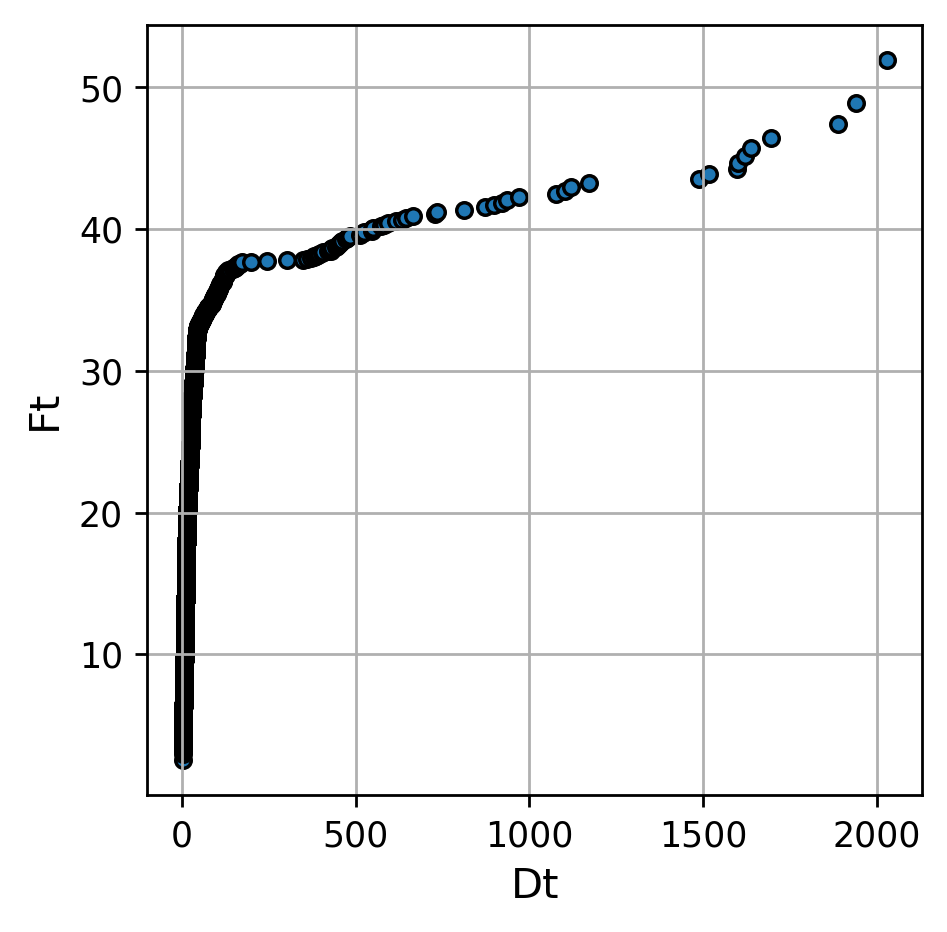

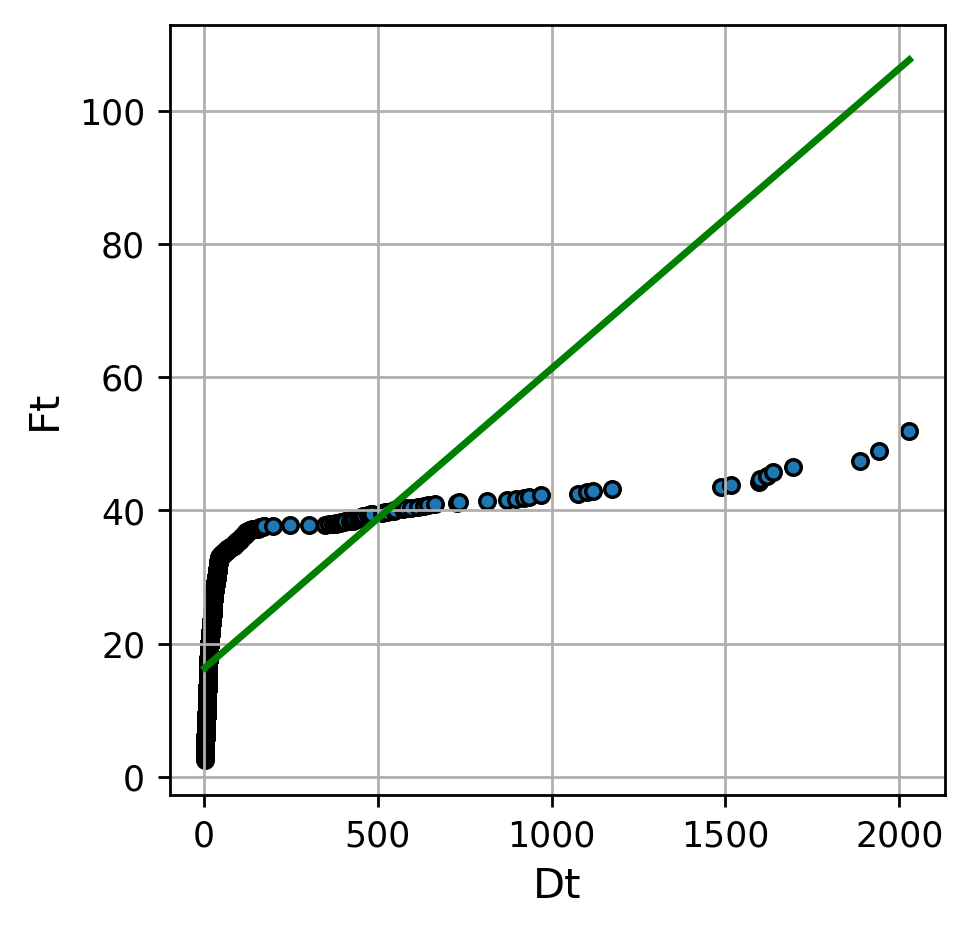

In [35]:
# Fit Dt y Ft to a line

linearFit = scipy.stats.linregress(Dt,Ft)
intercept, slope = linearFit[1], linearFit[0]

print('Intercept, Slope: ', intercept, slope) 

# plot Dt vs Ft
plt.figure(figsize=(4,4))
plt.scatter(Dt, Ft, edgecolor='black', s=20)
plt.xlabel('Dt', fontsize=12)
plt.ylabel('Ft', fontsize=12)
plt.grid()

# plot fit data vs fit a stright line.
x = np.linspace(Dt[0], Dt[-1])
y = slope*x + intercept

plt.figure(figsize=(4, 4))
plt.scatter(Dt, Ft, edgecolor='black', s=20)
plt.plot(x, y, color='green', ls='-', lw=2)
plt.xlabel('Dt', fontsize=12)
plt.ylabel('Ft', fontsize=12)
plt.grid()

In [36]:
# Significance test and results analysis.
Fbar = np.mean(Ft)
S = np.sqrt(((Ft - (intercept + slope * Dt))**2).sum() / (N-2))
S_by_Fbar = S / Fbar
print('S / Fbar: ', S_by_Fbar)

if S_by_Fbar > 0.15:
    gaussianity = False
else:
    if np.abs(slope - 1) < 0.2 and np.abs(intercept) < Fbar * 0.05:
        gaussianity = True
    else:
        gaussianity = False

print('Gaussianity: ', gaussianity)


S / Fbar:  0.32019056014960007
Gaussianity:  False


#### Conditions to multivariate gaussian distribution is assumed.

* if S/F > 0.15 Non gaussian distribution.

* If |slope -1|< 0.2 and |intercep|< F* 0.05 so is gaussian distribution.

# Multimodality Assesment.

Most industrial data sets exhibit multiple modes of operation due to variations in production levels, raw material compositions, ambient temperatures, product grades, etc. and data points from different modes tend to cluster into different groups.

Among the clustering techniques available in this project, we will use probabilistic clustering using Gaussian mixture modeling (GMM). Because the Gaussian mixture model (GMM) has been widely applied in multi-mode process monitoring to determine the number of modes automatically, as it works without any prior knowledge about the mode number.

To calculate the optimal number of clusters (operating modes) we use the BIC, which shows how the BIC varies with the number of components in the Gaussian mixture model.

* Lowest BIC: The lowest BIC value indicates the model that best balances model fit and model complexity. A lower BIC value suggests a better model in terms of fitted likelihood penalized by the number of parameters.

* Optimal number of components: The number of components that corresponds to the lowest BIC is the optimal number of clusters. This number represents the best partition of the data according to the BIC criterion.

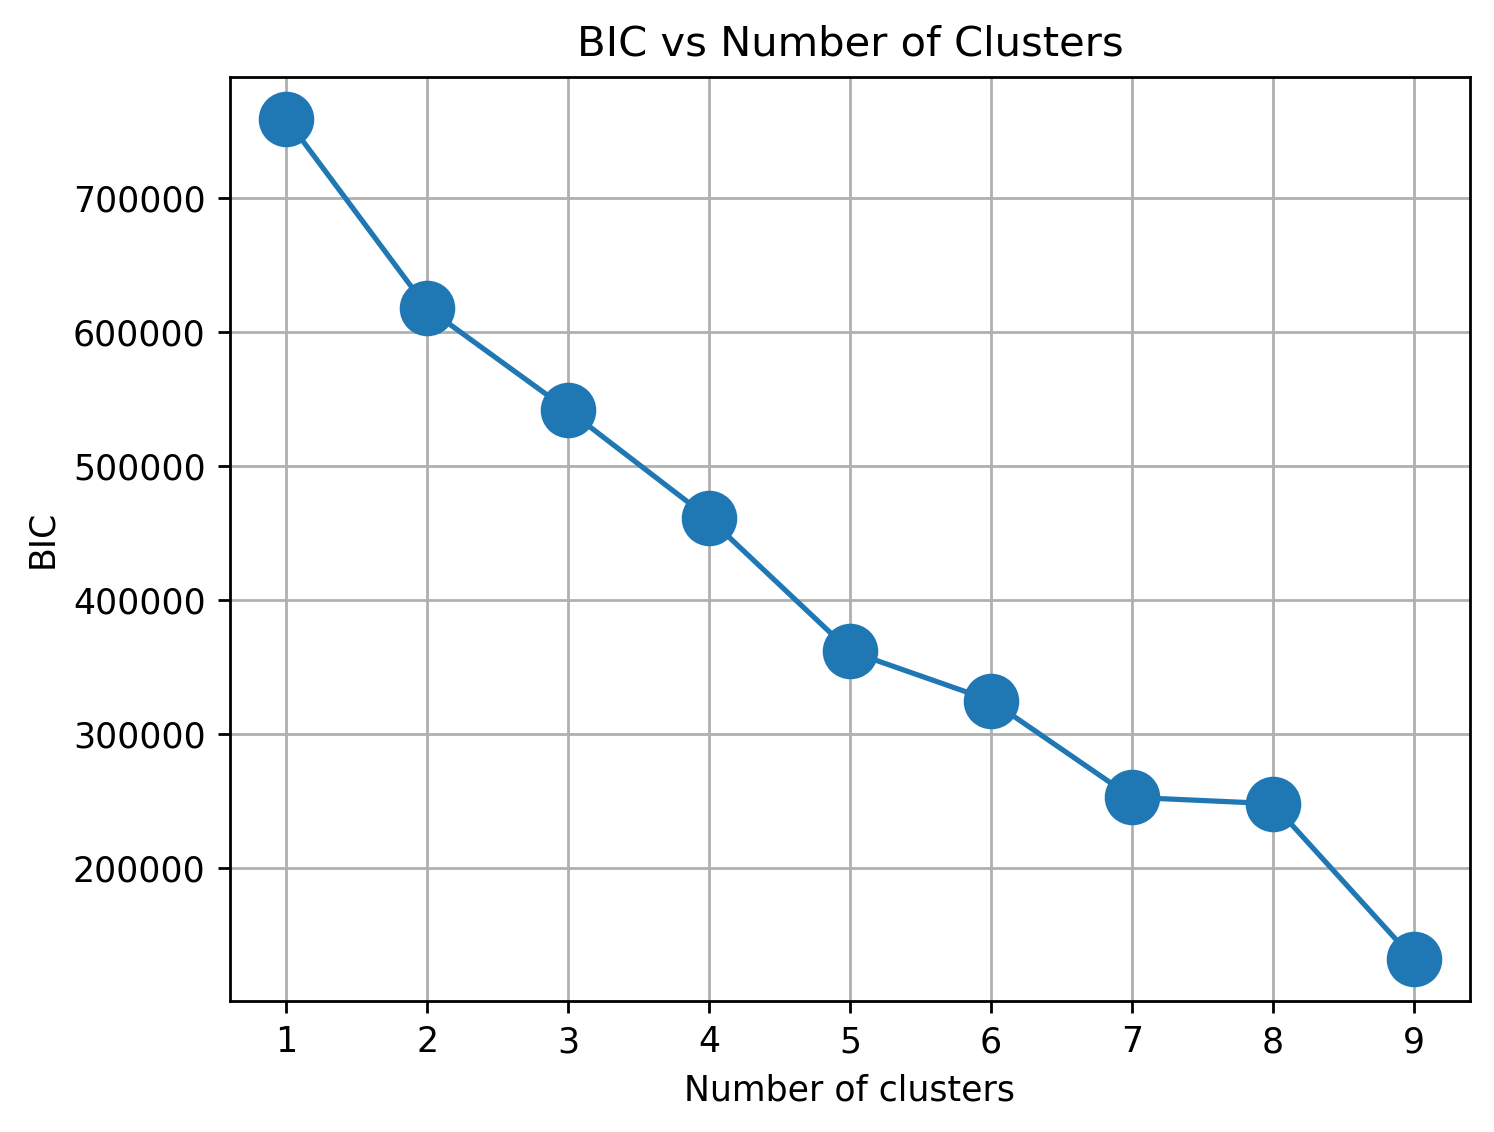

Optimal number of clusters: 9
Lowest BIC: 131896.93346766656


In [37]:
BICs = []
lowestBIC = np.inf

# Calculate BIC for different numbers of components
for n_cluster in range(1, 10):
    gmm = GaussianMixture(n_components=n_cluster, random_state=100)
    gmm.fit(data_numeric)
    BIC = gmm.bic(data_numeric)
    BICs.append(BIC)
    
    if BIC < lowestBIC:
        optimal_n_cluster = n_cluster
        lowestBIC = BIC

# Plot BIC for different numbers of components
plt.figure()
plt.plot(range(1, len(BICs) + 1), BICs, marker='o', ms=15)
plt.xlabel('Number of clusters')
plt.ylabel('BIC')
plt.title('BIC vs Number of Clusters')
plt.grid()
plt.show()

# Show the optimal number of components
print('Optimal number of clusters:', optimal_n_cluster)
print('Lowest BIC:', lowestBIC)